In [1]:
# imports
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn
import os
import string
from PIL import Image

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create a mapping from the image files to the character they represents
character_list = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
nums = range(1,len(character_list)+1)
file_to_character = dict(zip(nums, character_list))

In [10]:
# Take the median size of the images as the standard_size for 
# normalization of the images
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/English/img/'
img_sizes = []
for folder in os.listdir(path):
    for img_file in os.listdir(path+'/'+folder+'/'):
        img = Image.open(path+'/'+folder+'/'+img_file)
        img_sizes.append(img.size)

# resize function only takes int values
STANDARD_SIZE = map(int, median(img_sizes, axis=0))

In [6]:
# Create an image class that allows us to represent the image in matrix or vector from
class img():
    def __init__(self, img_file=None, img_path=None):
        if img_file is None or img_path is None:
            raise Exception('Must give an image file as input along'
                            'with its file name')
        self.img_matrix = None
        self.img_vector = None
        self.img_label = None
        self.img_file = img_file
        self.img_path = img_path
        
    def img_to_matrix(self):
        """
        Extract a matrix representation of the image
        """
        # Resize the image to a standard size
        img_resized = self.img_file.resize(STANDARD_SIZE)
        self.img_matrix = array(img_resized)

    def flatten_image(self):
        """
        Flatten the matrix representation of the image. If the
        matrix has shape (m, n) then the vector representation
        has shape (1, m * n)
        """
        if self.img_matrix is None:
            self.img_to_matrix()
        s = self.img_matrix.shape[0] * self.img_matrix.shape[1]
        self.img_vector = self.img_matrix.reshape(1, s)[0]

    def get_img_label(self):
        """"
        Sets the label for the image file, i.e, the English
        character the image is showing
        """
        file_name = self.img_path.split('/')[-1][3:6]
        self.img_label = file_to_character[int(file_name)]
        
# img1 = img(img_file=img_file, img_path='blahblah/im-001')
# img1.img_label
# img1.img_to_matrix()
# print img1.img_matrix
# img1.flatten_image()
# img1.img_vector
# img1.get_img_label()
# img1.img_label


In [7]:
# Gather features of the image for building the training data
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/English/img/'
data = []
labels = []
for folder in os.listdir(path):
    for img_file in os.listdir(path+'/'+folder+'/'):
        img_file = Image.open(path+'/'+folder+'/'+img_file)
        img_path = img_file.filename
        img_file = img_file.convert('L')
        
        # Open in the image file
#         img_file = img_file.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
        curr_img = img(img_file=img_file, img_path=img_path)
        
        # Take a vectore representation of the image
        curr_img.flatten_image()
        data.append(curr_img.img_vector)
        
        # add the label
        curr_img.get_img_label()
        labels.append(curr_img.img_label)

data = np.array(data)

In [8]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import svm

# Create the training data
pca = PCA(n_components=50)
X = pca.fit_transform(data)
df = DataFrame(X)
response = 'label'
df[response] = labels

# Divide data to test and train
mask = np.random.rand(len(df)) < 0.85
train_dat = df[mask]
test_dat = df[~mask]
y_test = np.array(test_dat[response])
test_dat.drop(response, axis=1, inplace=True)


/home/reza/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Run random forest on the train model and pick the number
# of trees used for the model
rf = RandomForestClassifier(n_estimators=1000, oob_score=True)
rf.fit(train_dat.drop(response, axis=1), train_dat[response])
prediction = rf.predict(test_dat)

# Check error percentage on the test set and tune parameters
mean(prediction != y_test)

0.42517605633802819

In [124]:
# Lets test this on a sample image
path = '/home/reza/Downloads/test.jpg'
img_file = Image.open(path)
img_path = img_file.filename
img_file = img_file.convert('L')
        
# Open in the image file
img_file = img_file.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
curr_img = img(img_file=img_file, img_path=img_path)
        
# Take a vectore representation of the image
curr_img.flatten_image()
test_point = pca.transform(curr_img.img_vector)

# Predict the label for the test point
rf.predict(test_point)

array(['N'], dtype=object)

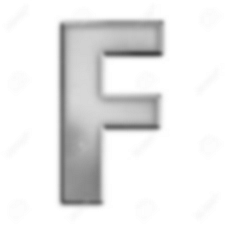

In [55]:
from PIL import ImageFilter
img_file.filter(ImageFilter.SHARPEN)


## Using a different Dataset for Handwriting Recognition

In [2]:
# Read the symbols in the data
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/coordinate/'
symbols = pd.read_csv(path+'symbols.csv', error_bad_lines=False, delimiter=';')

# Create a mapping from the symbol to the character it represents
id_to_char = dict(zip(symbols.symbol_id.astype(str), symbols.latex))

In [145]:
import csv
import json

# Create a dictionary with keys alphanumeric characters
# and values strokes. Each stroc consists of a set of 
# (x,y,t) coordinates
recordings = []
with open(path+'train-data.csv', 'rb') as csvfile:
    data = csv.reader(csvfile, delimiter=';')
    next(data, None)
    for row in data:
        symbol = id_to_char[row[0]]
        if symbol.isalnum():
            record = dict()
            record[symbol] = json.loads(row[2])
            recordings.append(record)

In [111]:
# Find the distribution distance between strokes
def find_dist(x,y):
    x = np.array([x['x'], x['y']])
    y = np.array([y['x'], y['y']])
    return sqrt(sum((x-y)**2))
    
stroke_dist = []
for record in recordings:
    drawing = record[record.keys()[0]]
    for i in range(1, len(drawing)):
        # current point
        s_curr = drawing[i][0]
        
        # previous point
        s_prev = drawing[i-1][-1]
        stroke_dist.append(find_dist(s_curr, s_prev))


(array([ 203.,  210.,  385.,  393.,  352.,  193.,   86.,   37.,   10.,    5.]),
 array([   0.        ,   36.49657492,   72.99314984,  109.48972476,
         145.98629967,  182.48287459,  218.97944951,  255.47602443,
         291.97259935,  328.46917427,  364.96574918]),
 <a list of 10 Patch objects>)

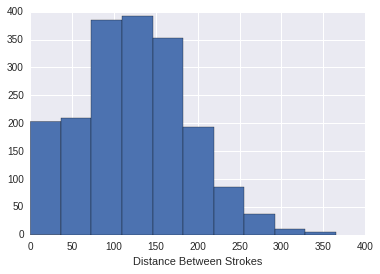

In [63]:
# Plot the distribution of distance between strokes
plt.xlabel('Distance Between Strokes')
plt.hist(stroke_dist)

In [64]:
# Find some stats on distance between strokes
threshold = 10
percent_low_dist = len(filter(lambda x: x < threshold, stroke_dist))/float(len(stroke_dist)) * 100
print 'There are %{} of the strokes with distance less than {}'.format(percent_low_dist, threshold)

There are %4.64247598719 of the strokes with distance less than 10


In [143]:
# Some configuration needed for modifying the drawing record
STOROKE_CONNECT_THERESHOLD=10
FACTOR_CORRECTION = 0.00001
DEHOOK_THRESHOLD = 3
DEHOOK_ANGLE_THRESHOLD_BEG = 80
DEHOOK_ANGLE_THRESHOLD_END = 80

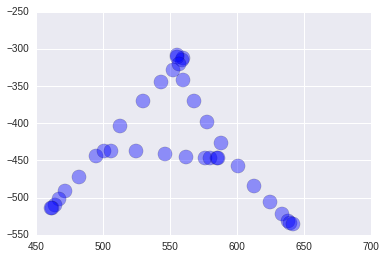

9.86707180554 beg=True
63.4352993563 beg=False
11.3116456473 beg=True
11.3117397283 beg=False
0.128789685233 beg=True
0.280689678906 beg=False


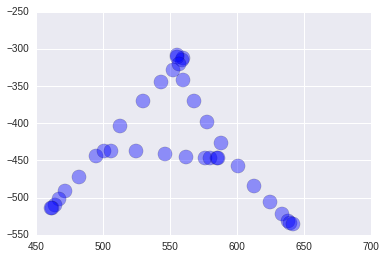

[[{u'time': 1400928965480, u'x': 560, u'y': 312},
  {u'time': 1400928965534, u'x': 559, u'y': 315},
  {u'time': 1400928965551, u'x': 552, u'y': 328},
  {u'time': 1400928965567, u'x': 543, u'y': 344},
  {u'time': 1400928965584, u'x': 530, u'y': 370},
  {u'time': 1400928965600, u'x': 513, u'y': 404},
  {u'time': 1400928965617, u'x': 495, u'y': 444},
  {u'time': 1400928965633, u'x': 482, u'y': 472},
  {u'time': 1400928965650, u'x': 472, u'y': 491},
  {u'time': 1400928965667, u'x': 467, u'y': 502},
  {u'time': 1400928965683, u'x': 464, u'y': 510},
  {u'time': 1400928965700, u'x': 462, u'y': 514},
  {u'time': 1400928965717, u'x': 461, u'y': 514}],
 [{u'time': 1400928966493, u'x': 555, u'y': 309},
  {u'time': 1400928966518, u'x': 555, u'y': 311},
  {u'time': 1400928966534, u'x': 557, u'y': 321},
  {u'time': 1400928966551, u'x': 560, u'y': 342},
  {u'time': 1400928966568, u'x': 568, u'y': 370},
  {u'time': 1400928966584, u'x': 578, u'y': 399},
  {u'time': 1400928966601, u'x': 588, u'y': 427},

In [151]:
# Create a class drawing_record that has methods to
# handle each record (scaling, resampling, feature extraction)
class drawing_record():
    def  __init__(self, record):
        self.coordinates = record
    def find_bounding_box(self):
        """
        Find the bounding box of the drawing character
        """
        mint, minx, miny = [float('inf')]*3
        maxx, maxy, maxt = [float('-inf')]*3
        for stroke in self.coordinates:
            for point in stroke:
                if point['time'] < mint:
                    mint = point['time']
                if point['x'] < minx:
                    minx = point['x']
                if point['y'] < miny:
                    miny = point['y']
                if point['x'] > maxx:
                    maxx = point['x']
                if point['y'] > maxy:
                    maxy = point['y']
        return (mint, minx, maxx, miny, maxy)
    
    def stroke_connect(self):
        """
        Connects two srokes if the distance betwen them
        is unusualy close
        """
        for i in range(1, len(self.coordinates)):
            # current point
            s_curr = self.coordinates[i][0]
        
            # previous point
            s_prev = self.coordinates[i-1][-1]
            if find_dist(s_curr, s_prev) < STOROKE_CONNECT_THERESHOLD:
                pass
 
    
    def dehook(self, beg=False, end=False):
        """
        Removes hooks at the begining or end of a stroke
        """
        if not beg and not end:
            print 'Dehooking was not done, set beg or end to True'
            return
        # Given three points p0,p1,p2 in order, it calculates
        # the angle between p_10 and p_21
        def calculate_angle(points):
            # Return euclidean distance between two points
            def diff(v,w):
                v = np.array([v['x'], v['y']])
                w = np.array([w['x'], w['y']])
                return v-w
            p_10 = diff(points[0], points[1])
            p_21 = diff(points[1], points[2])
            # Find the cosine of the angle
            cos_angle = float(p_10.dot(p_21))/((sqrt(p_10.dot(p_10)) + 
                                                FACTOR_CORRECTION) * 
                                               (sqrt(p_21.dot(p_21)) +
                                                FACTOR_CORRECTION))
            angle = arccos(cos_angle) * 180/pi
            return angle
        
        # Dehooks at the begining
        def dehook_stroke(all_points, one_point, three_points, angle,
                          beg=False, end=False):
            if calculate_angle(three_points) < angle:
                print calculate_angle(three_points), 'beg={}'.format(beg)
                return all_points
            else:
                print calculate_angle(three_points), 'dehooked', 'beg={}'.format(beg)
                if beg:
                    return dehook_stroke(all_points[1:],
                                         all_points[2],
                                         all_points[1:4],
                                         angle,
                                         beg=beg)
                if end:
                    return dehook_stroke(all_points[:-2],
                                         all_points[-2],
                                         all_points[-4:-1],
                                         angle,
                                         end=end)                    
        
        if len(self.coordinates) < DEHOOK_THRESHOLD:
            return
        for i, stroke in enumerate(self.coordinates):
            if beg:
                self.coordinates[i] = dehook_stroke(stroke,
                                                    stroke[0],
                                                    stroke[:3],
                                                    DEHOOK_ANGLE_THRESHOLD_BEG,
                                                    beg=beg,
                                                    end=False)
            if end:
                self.coordinates[i] = dehook_stroke(self.coordinates[i],
                                                    stroke[-1],
                                                    stroke[-3:],
                                                    DEHOOK_ANGLE_THRESHOLD_END,
                                                    end=end,
                                                    beg=False)
    
    def scale_shift(self):
        """
        Scale and shif the coordinates of the drawing.
        Only the smaller dimension gets centered
        """
        mint, minx, maxx, miny, maxy = self.find_bounding_box()
        for stroke in self.coordinates:
            for point in stroke:
                width = (maxx-minx) + FACTOR_CORRECTION
                height = (maxy-miny) + FACTOR_CORRECTION
                fx = 1.0/width
                fy = 1.0/height
                f = min(fx,fy)
                add = min(width, height)/2.0 * f
                addx, addy = 0, 0
                if f == fx:
                    addx = add
                else:
                    addy = add
                point['x'] = (point['x'] - minx) * f - addx
                point['y'] = (point['y'] - miny) * f - addy
                point['time'] = point['time'] - mint

    def resample(self):
        pass
    def plot_drawing(self):
        x_val = []
        y_val = []
        for stroke in self.coordinates:
            for point in stroke:
                x_val.append(point['x'])
                y_val.append(-point['y'])
        plt.scatter(x_val, y_val, s=200, alpha=0.4)
        plt.show(block=False)
dr = drawing_record(recordings[4]['A'])
dr.plot_drawing()
# print dr.coordinates[0][-1]
# print dr.coordinates[1][-1]
# print dr.coordinates[2][-1]
dr.dehook(beg=True, end=True)
# dr.scale_shift()
dr.plot_drawing()
dr.coordinates

In [434]:
for i in range(200000):
    for key, _ in recordings[i].items():
        if len(recordings[i][key]) == 3:
            print i
            break

4
30
32
33
34
35
36
37
38
39
44
53
64
65
67
76
78
81
84
94
95
105
110
111
115
117
121
124
127
136
148
151
153
183
302
331
360
362
363
364
365
367
368
372
378
380
383
384
385
386
387
388
389
394
395
396
397
398
399
400
401
402
403
404
405
407
408
409
411
412
413
414
415
416
417
418
420
424
425
426
427
428
429
430
431
432
433
434
435
436
437
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
457
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
594
595
596
597
598
599
600
601
603
604
605
606
607
608
609
610
611
612
613
614
615
616
618
619
620
628
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
675
676
677
679
680
681
683
684
685
686
688
692
693
694
695
696
697
698
700
701
702
703
704
707
708
851
852
855
856
861
863
864
865
867
887
888
1047
1091
1439
1440
1443
1513
1536
1664
1804
1825
2063
2064
2316
2339


IndexError: list index out of range

In [25]:
recordings[390].keys()
# a = ['1', 'gt']
# list(reversed(a))

['E']